# Vapor Pressure Data Representation by Polynomials and Equations
This is the third problem of the famous set of [Ten Problems in Chemical Engineering](https://www.polymath-software.com/ASEE/Tenprobs.pdf).  Here, the goal is to perform Nonlinear regression.

Jacob Albrecht, 2019

# Problem Setup
Given the data for benzene from Perry's, regress the data to a polynomial:

$$P=\beta_0+\beta_1T+\beta_2T^2+...+\beta_nT^n$$

or the Clausius-Clapeyron equation;

$$log(P) = A - \frac{B}{T+273.15}$$

or the Antoine equation:

$$log(P) = A - \frac{B}{T+C}$$


In [1]:
import pandas as pd
df = pd.DataFrame([[-36.7,1],
                   [-19.6,5],
                   [-11.5,10],
                   [-2.6,20],
                   [7.6,40],
                   [15.4,60],
                   [26.1,100],
                   [42.2,200],
                   [60.6,400],
                   [80.1,760]],columns=['T','P'])
df

,T,P
0,-36.7,1
1,-19.6,5
2,-11.5,10
3,-2.6,20
4,7.6,40
5,15.4,60
6,26.1,100
7,42.2,200
8,60.6,400
9,80.1,760


# Problem Tasks
a) Regress the data with polynomials. Determine the degree ofpolynomial which best represents the data.

b) Regress the data using linear regression on the Clausius-Clapeyron equation.

c) Regress the data using nonlinear regression on the Antoine equation.


# Solutions

## Solution to part a)
Fit the data to different order polynomials.  This is done by looping over a few polynomial orders and using the `numpy` `polyfit` function to do the fit, and return the polynomial coefficients and sum of the squared errors for the prediction.  The plots of the predictions are created using the `matplotlib` library.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Poly order 1, SSQ: [118590.55617491]
Poly order 2, SSQ: [8517.49512142]
Poly order 3, SSQ: [204.73336714]
Poly order 4, SSQ: [1.98960128]
Poly order 5, SSQ: [1.94361278]


Text(0, 0.5, 'P, mm Hg')

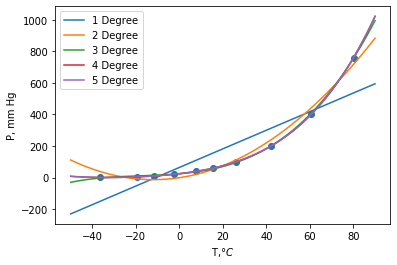

In [3]:
x=np.linspace(-50,90,num=100)
plt.scatter(df['T'],df['P'])
for p in np.arange(1,6):
    betas, residuals, rank, singular_values, rcond = np.polyfit(df['T'],df['P'],p,full=True)
    plt.plot(x,np.polyval(betas,x),label = '{} Degree'.format(p))
    print('Poly order {}, SSQ: {}'.format(p,residuals))
plt.legend()
plt.xlabel('T,$\degree C$')
plt.ylabel('P, mm Hg')

With higher degrees of polynomials, the sum of the squared error will eventually go to zero as the polynomial goes to greater lengths to pass through each of the points.  There is less benefit to lower SSQ for polynomial orders over 4, though the 3rd order polynomial appears to be satisfactory.

## Solution to part b)

For the fit to the Clausius-Clapeyron equation, the original data should be transformed.  Adding new columns to pandas dataframe is as easy as assigning values to a new column:

In [4]:
df['logP'] = np.log10(df['P'])
df['T,K'] = df['T']+273.15
df['1/(T,K)'] = 1/df['T,K']

In [5]:
betas, residuals, rank, singular_values, rcond  = np.polyfit(df['1/(T,K)'],df['logP'],1,full=True)
print(betas)
print('SSQ for logP: {:.2}'.format(residuals[0]))

[-2035.33102614     8.75200997]
SSQ for logP: 0.061


Text(0.5, 0, '1/T, $K^{-1}$')

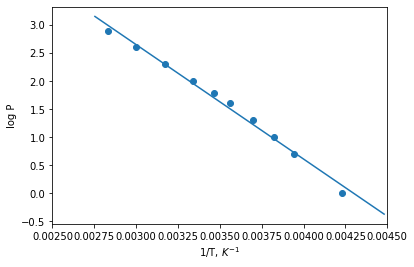

In [6]:
plt.scatter(df['1/(T,K)'],df['logP'])
plt.plot(1/(x+273.15),np.polyval(betas,1/(x+273.15)))
plt.xlim([0.0025,0.0045])
plt.ylabel('log P')
plt.xlabel('1/T, $K^{-1}$')



## Solution to part c)

Fit the values to the Antoine equation.  For the nonlinear regression, we can use `scipy`'s `curve_fit` function, available in the optimize subpackage.  Lets try two types of regression, one minimizing the sum of squared errors for the vapor pressure, and the other minimizing the sum of squared errors for the log of the vapor pressure.  It makes a difference what metric we use.  To start, evaluate regressing the 


Antoine parameters A: 6.6, B: 1.054e+03, C: 202.0
SSQ for logP: 0.085
SSQ for P: 15.96


Text(0, 0.5, 'P, mm Hg')

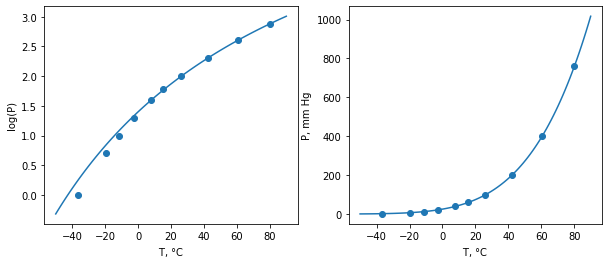

In [7]:
from scipy.optimize import curve_fit

def antoine_P(T,A,B,C):
    return(10**(A-B/(T+C)))

popt, pcov = curve_fit(antoine_P,df['T'],df['P'],p0=[10,2000,100])
preds = antoine_P(df['T'],*popt)
print('Antoine parameters A: {:.2}, B: {:.4}, C: {:.4}'.format(*popt))
print('SSQ for logP: {:.2}'.format(np.sum((df['logP'] - np.log10(preds))**2)))
print('SSQ for P: {:.4}'.format(np.sum((df['P'] - preds)**2)))

plt.figure(figsize = (10,4)) # make figure width at least twice the height

plt.subplot(1,2,1) # subplot 1
plt.scatter(df['T'],df['logP'])
plt.plot(x,np.log10(antoine_P(x,*popt)))
plt.xlabel('T, $\degree$C')
plt.ylabel('log(P)')

plt.subplot(1,2,2) # subplot 2
plt.scatter(df['T'],df['P'])
plt.plot(x,antoine_P(x,*popt))  
plt.xlabel('T, $\degree$C')
plt.ylabel('P, mm Hg')



Next regress the log-transformed vapor pressure, the previous code cell can be copied with some very slight changes:

Antoine parameters A: 5.8, B: 677.1, C: 153.9
SSQ for logP: 0.0022
SSQ for P: 267.0


Text(0, 0.5, 'P, mm Hg')

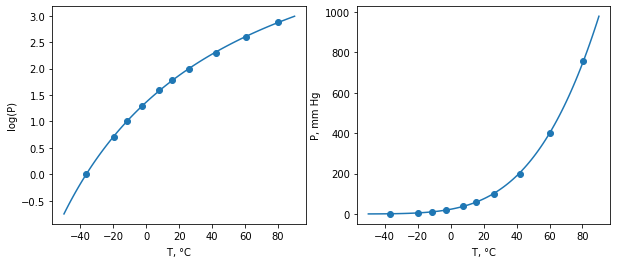

In [8]:

def antoine_logP(T,A,B,C):
    return((A-B/(T+C)))

popt, pcov = curve_fit(antoine_logP,df['T'],df['logP'],p0=[10,2000,100])
logpreds = antoine_logP(df['T'],*popt)
print('Antoine parameters A: {:.2}, B: {:.4}, C: {:.4}'.format(*popt))

print('SSQ for logP: {:.2}'.format(np.sum((df['logP'] - logpreds)**2)))
print('SSQ for P: {:.4}'.format(np.sum((df['P'] - 10**logpreds)**2)))

plt.figure(figsize = (10,4)) # make figure width at least twice the height

plt.subplot(1,2,1) # subplot 1
plt.scatter(df['T'],df['logP'])
plt.plot(x,antoine_logP(x,*popt))  # the * is a trick to expand 'popt' it is the same as 'antoine_logP(x,popt[0],popt[1],popt[2])'
plt.xlabel('T, $\degree$C')
plt.ylabel('log(P)')

plt.subplot(1,2,2) # subplot 2
plt.scatter(df['T'],df['P'])
plt.plot(x,10**antoine_logP(x,*popt))  # the * is a trick to expand 'popt' it is the same as 'antoine_logP(x,popt[0],popt[1],popt[2])'
plt.xlabel('T, $\degree$C')
plt.ylabel('P, mm Hg')


Depending on the metric used, the regressed values for A, B, and C are different, and the SSQ metrics can change by an order of magitude.  The log transform put more weight on fitting the low pressure data points, this is important to keep in mind.

# Reference
“The Use of Mathematical Software packages in Chemical Engineering”, Michael B. Cutlip, John J. Hwalek, Eric H.
Nuttal, Mordechai Shacham, Workshop Material from Session 12, Chemical Engineering Summer School, Snowbird,
Utah, Aug., 1997.

Perry,  R.H.,  Green,  D.W.,  and  Malorey,  J.D.,  Eds.  Perry’s  Chemical  Engineers  Handbook.  New  York:McGraw-Hill, 1984.
